In [1]:
from tope import Tope
from tope.net import *
from tope.orth import *
import polytope

In [2]:
simplex = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[1,2,3,5],[-2,-3,-4,-5]]
import json
with open("polys.json") as fd: polys = json.load(fd)

In [3]:
import numpy as np
rng = np.random.default_rng()

In [4]:
#_, vertices = polys.popitem()
P = Tope.from_vertices([[1, 0, 0, 0], [1, 2, 0, 0], [1, 0, 2, 0], [1, 0, 0, 2], [-3, -2, -2, -2], [-3, -4, -2, 0], [-3, 2, -2, -2], [-3, -4, -2, 4]])

2022-06-07 15:55:08.204 | DEBUG    | tope.tope:from_vertices:37 - Computing from set of 8 vertices.
2022-06-07 15:55:08.216 | DEBUG    | tope.tope:from_vertices:70 - Extracting 2-diml faces...
2022-06-07 15:55:08.216 | DEBUG    | tope.tope:from_vertices:88 - Processing removals {0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 28, 29, 31, 35}.
2022-06-07 15:55:08.216 | DEBUG    | tope.tope:from_vertices:70 - Extracting 1-diml faces...
2022-06-07 15:55:08.216 | DEBUG    | tope.tope:from_vertices:88 - Processing removals {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 66, 69, 70, 71, 72, 73}.
2022-06-07 15:55:08.216 | DEBUG    | tope.tope:from_vertices:92 - Finished processing faces:
 [[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}], [{2, 5}, {2, 4}, {0, 2}, {2, 7}, {2, 3}, {2, 6}, {1,

In [5]:
for k in range(P.dim):
    for i in range(len(P.faces[k])):
        P.verify_face(i, k)

2022-06-07 15:55:08.922 | INFO     | tope.tope:verify_face:102 - 0-face 0 has affine dimension 0.
2022-06-07 15:55:08.922 | INFO     | tope.tope:verify_face:102 - 0-face 1 has affine dimension 0.
2022-06-07 15:55:08.927 | INFO     | tope.tope:verify_face:102 - 0-face 2 has affine dimension 0.
2022-06-07 15:55:08.928 | INFO     | tope.tope:verify_face:102 - 0-face 3 has affine dimension 0.
2022-06-07 15:55:08.928 | INFO     | tope.tope:verify_face:102 - 0-face 4 has affine dimension 0.
2022-06-07 15:55:08.928 | INFO     | tope.tope:verify_face:102 - 0-face 5 has affine dimension 0.
2022-06-07 15:55:08.928 | INFO     | tope.tope:verify_face:102 - 0-face 6 has affine dimension 0.
2022-06-07 15:55:08.928 | INFO     | tope.tope:verify_face:102 - 0-face 7 has affine dimension 0.
2022-06-07 15:55:08.928 | INFO     | tope.tope:verify_face:102 - 1-face 0 has affine dimension 1.
2022-06-07 15:55:08.928 | INFO     | tope.tope:verify_face:102 - 1-face 1 has affine dimension 1.
2022-06-07 15:55:08.

In [6]:
# need to get the net in its own span
def put_in_own_span(N: Net):
    offsets = [0] + [len(vertices) for vertices in N.facets.values()]
    offsets = np.cumsum(offsets)
    all_vertices = np.concatenate(list(N.facets.values()))
    all_vertices = in_own_span(all_vertices - all_vertices.mean(axis=0))
    for i in N.facets:
        N.facets[i] = all_vertices[offsets[i]:offsets[i+1]]

In [18]:
EdgeList = list[np.ndarray] # list of 2xdim arrays

def get_edges(N: Net) -> EdgeList: # apply to unfolded Net
    edges = []
    for i, vertices in N.facets.items():
        facet_template = N.tope.get_face(i) # has correct indices
        edges.extend((vertices[list(e)] for e in facet_template.faces[1]))
    return edges

FacetLabels = list[tuple[str, np.ndarray]]

def get_facet_labels(N: Net) -> FacetLabels:
    labels = []
    for i, vertices in N.facets.items():
        labels.append((N.tope.labels[-1][i], vertices.mean(axis=0)))
    return labels

In [8]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection # container for line segments
from matplotlib.text import Text, Annotation
import matplotlib.cm as cm # colour mappings
import random

edges = get_edges(N)
        
fig, ax = plt.subplots()

lc = LineCollection(edges)
ax.add_collection(lc)
for label, pos in get_facet_labels(N):
    ax.add_artist(Text(*pos, text=str(label)))

ax.autoscale()
fig.savefig("fig.png")
fig.show()

In [19]:
def get_net_for_facet(P: Tope, i: int) -> Net:
    F=P.get_face(i)
    labels = F.labels
    F = F.in_own_span
    if F.vertices.shape[1] >= P.vertices.shape[1]:
        print("Failed: facet doesn't live in a subspace.")
        return False
    F.labels = labels
    
    G = get_facet_graph(F)
    T = G.get_spanning_tree(root=0, skip=set())
    N = Net(F, T)
    N.unfold()
    
    put_in_own_span(N)
    #print(N.facets)
    if N.facets[0].shape[1] > 2:
        print("Failed: net doesn't live in a plane.")
        return False
    
    return N

def save_net(P: Tope, i: int):
    F=P.get_face(i)
    labels = F.labels
    F = F.in_own_span
    if F.vertices.shape[1] >= P.vertices.shape[1]:
        print("Failed: facet doesn't live in a subspace.")
        return False
    F.labels = labels
    
    G = get_facet_graph(F)
    T = G.get_spanning_tree(root=0, skip=set())
    N = Net(F, T)
    N.unfold()
    
    put_in_own_span(N)
    #print(N.facets)
    if N.facets[0].shape[1] > 2:
        print("Failed: net doesn't live in a plane.")
        return False
        
    fig, ax = plt.subplots()
    
    lc = LineCollection(get_edges(N))
    ax.add_collection(lc)
    for label, pos in get_facet_labels(N):
        ax.add_artist(Text(*pos, text=str(label)))

    ax.set_xlim(-11,10)
    ax.set_ylim(-7,7)
    #ax.autoscale()
    fig.savefig(f"figs/facet-{i}.png", dpi=300)

In [38]:
MARGIN_FACTOR = 1.1

def save_nets(P: Tope, fname: str, margin_factor: float = MARGIN_FACTOR, dpi: int = 300):
    nfacets = len(P.faces[-1])
    fig, axes_list = plt.subplots(nfacets)
    facet_net_list = []
    
    xlim = [0,0]
    ylim = [0,0]

    for i in range(nfacets):
        N = get_net_for_facet(P, i)
        for face_v in N.facets.values():
            lower, upper = face_v.min(axis=0), face_v.max(axis=0)
            xlim[0] = min(xlim[0], lower[0])
            ylim[0] = min(ylim[0], lower[1])
            xlim[1] = max(xlim[1], upper[0])
            ylim[1] = max(ylim[1], upper[1])
        facet_net_list.append(N)
        
    xlim[0] *= margin_factor
    ylim[0] *= margin_factor
    xlim[1] *= margin_factor
    ylim[1] *= margin_factor
        
    for i in range(nfacets):
        N = facet_net_list[i]
        ax = axes_list[i]
        lc = LineCollection(get_edges(N))
        ax.add_collection(lc)
        for label, pos in get_facet_labels(N):
            ax.add_artist(Text(*pos, text=str(label)))

        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        
    fig.set_figheight(5*nfacets) # 5 what?
    fig.savefig(fname, dpi=dpi)

2022-06-07 16:56:19.868 | DEBUG    | tope.tope:from_vertices:37 - Computing from set of 14 vertices.
2022-06-07 16:56:19.871 | DEBUG    | tope.tope:from_vertices:70 - Extracting 2-diml faces...
2022-06-07 16:56:19.873 | DEBUG    | tope.tope:from_vertices:88 - Processing removals {0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 32, 33, 34, 36, 37, 40, 41, 44, 48}.
2022-06-07 16:56:19.874 | DEBUG    | tope.tope:from_vertices:70 - Extracting 1-diml faces...
2022-06-07 16:56:19.876 | DEBUG    | tope.tope:from_vertices:88 - Processing removals {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 109, 111, 116, 117, 118

2022-06-07 16:56:20.169 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 39.23 degrees...
2022-06-07 16:56:20.169 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 140.77 degrees...
2022-06-07 16:56:20.169 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and set()
2022-06-07 16:56:20.169 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3, 4, 5} is empty
2022-06-07 16:56:20.184 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0}
2022-06-07 16:56:20.184 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {1, 2, 3, 4, 5} is empty
2022-06-07 16:56:20.184 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1}
2022-06-07 16:56:20.184 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {2, 3, 4, 5} is empty
2022-06-07 16:56:20.184 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1, 2}
2022-06-07 16:56:20.184 | DEBUG    | tope.gra

2022-06-07 16:56:21.796 | DEBUG    | tope.tope:from_vertices:92 - Finished processing faces:
 [[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}], [{12, 6}, {8, 13}, {9, 5}, {11, 5}, {2, 7}, {1, 4}, {2, 6}, {8, 6}, {5, 6}, {8, 10}, {8, 5}, {1, 5}, {0, 5}, {2, 3}, {1, 2}, {0, 1}, {12, 7}, {12, 13}, {9, 12}, {10, 13}, {11, 13}, {9, 4}, {9, 11}, {0, 11}, {3, 7}, {4, 7}, {0, 4}, {10, 3}, {0, 10}, {0, 3}], [{2, 12, 6, 7}, {8, 12, 13, 6}, {9, 12, 5, 6}, {8, 10, 13}, {8, 13, 11, 5}, {1, 4, 5, 9}, {9, 11, 5}, {0, 11, 5}, {2, 3, 7}, {1, 2, 4, 7}, {0, 1, 4}, {2, 3, 6, 8, 10}, {1, 2, 5, 6}, {8, 5, 6}, {0, 8, 10, 5}, {0, 1, 5}, {0, 1, 2, 3}, {3, 7, 10, 12, 13}, {9, 4, 12, 7}, {9, 11, 12, 13}, {0, 10, 11, 13}, {0, 9, 11, 4}, {0, 3, 4, 7}, {0, 10, 3}], [{2, 3, 6, 7, 8, 10, 12, 13}, {1, 2, 4, 5, 6, 7, 9, 12}, {5, 6, 8, 9, 11, 12, 13}, {0, 5, 8, 10, 11, 13}, {0, 1, 4, 5, 9, 11}, {0, 1, 2, 3, 4, 7}, {0, 1, 2, 3, 5, 6, 8, 10}, {0, 3, 4, 7, 9, 10, 11, 12, 13}]]
2022-06-07 16:56:21

2022-06-07 16:56:22.022 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1}
2022-06-07 16:56:22.022 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {2, 3, 4, 5} is empty
2022-06-07 16:56:22.022 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1, 2}
2022-06-07 16:56:22.022 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {3, 4, 5} is empty
2022-06-07 16:56:22.037 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1, 2, 4}
2022-06-07 16:56:22.037 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {3, 5} is empty
2022-06-07 16:56:22.037 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1, 2, 3, 4}
2022-06-07 16:56:22.037 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {5} is empty
2022-06-07 16:56:22.037 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 120.00 degrees...
2022-06-07 16:56:22.037 | DEBUG    | tope.orth:rotate_i

2022-06-07 16:56:23.519 | DEBUG    | tope.tope:from_vertices:92 - Finished processing faces:
 [[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}], [{10, 7}, {8, 7}, {0, 3}, {8, 11}, {8, 3}, {8, 5}, {4, 7}, {0, 7}, {5, 7}, {5, 6}, {1, 5}, {9, 4}, {0, 2}, {0, 4}, {4, 6}, {0, 1}, {2, 10}, {10, 11}, {9, 10}, {2, 3}, {3, 11}, {11, 6}, {1, 3}, {9, 2}, {9, 6}, {1, 2}, {1, 6}], [{0, 2, 10, 7}, {8, 10, 11, 7}, {9, 10, 4, 7}, {0, 2, 3}, {0, 8, 3, 7}, {8, 5, 7}, {0, 1, 3}, {8, 11, 3}, {8, 11, 5, 6}, {8, 1, 3, 5}, {0, 4, 7}, {4, 5, 6, 7}, {0, 1, 5, 7}, {1, 5, 6}, {0, 9, 2, 4}, {9, 4, 6}, {0, 1, 2}, {0, 1, 4, 6}, {10, 11, 2, 3}, {9, 2, 10}, {9, 10, 11, 6}, {1, 2, 3}, {11, 1, 3, 6}, {1, 2, 6, 9}], [{0, 2, 3, 7, 8, 10, 11}, {0, 2, 4, 7, 9, 10}, {4, 5, 6, 7, 8, 9, 10, 11}, {0, 1, 2, 3}, {0, 1, 3, 5, 7, 8}, {1, 3, 5, 6, 8, 11}, {0, 1, 4, 5, 6, 7}, {0, 1, 2, 4, 6, 9}, {1, 2, 3, 6, 9, 10, 11}]]
2022-06-07 16:56:23.719 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} an

2022-06-07 16:56:23.835 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4} and {0, 1, 2, 3}
2022-06-07 16:56:23.835 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {4} is empty
2022-06-07 16:56:23.851 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 90.00 degrees...
2022-06-07 16:56:23.851 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 116.57 degrees...
2022-06-07 16:56:23.851 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 63.43 degrees...
2022-06-07 16:56:23.851 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 125.26 degrees...
2022-06-07 16:56:23.851 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4} and set()
2022-06-07 16:56:23.851 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3, 4} is empty
2022-06-07 16:56:23.851 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4} and {0}
2022-06-07 16:56:23.867 | DEBUG    | tope.graph:get_spanning_tree:5

2022-06-07 16:56:26.116 | DEBUG    | tope.tope:from_vertices:92 - Finished processing faces:
 [[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}], [{5, 7}, {1, 4}, {4, 5}, {1, 7}, {4, 7}, {2, 4}, {0, 4}, {6, 7}, {0, 7}, {1, 5}, {2, 5}, {3, 5}, {0, 5}, {1, 6}, {1, 3}, {0, 1}, {2, 6}, {2, 3}, {0, 2}, {3, 6}, {0, 6}, {0, 3}], [{3, 5, 6, 7}, {4, 5, 7}, {1, 5, 7}, {1, 4, 5}, {1, 4, 7}, {0, 1, 4}, {2, 4, 5}, {0, 4, 5}, {1, 6, 7}, {0, 1, 7}, {2, 4, 6, 7}, {0, 4, 7}, {0, 2, 4}, {0, 6, 7}, {1, 3, 5}, {0, 1, 5}, {2, 3, 5}, {0, 2, 5}, {0, 3, 5}, {1, 3, 6}, {0, 1, 6}, {0, 1, 3}, {2, 3, 6}, {0, 2, 6}, {0, 2, 3}, {0, 3, 6}], [{2, 3, 4, 5, 6, 7}, {1, 3, 5, 6, 7}, {1, 4, 5, 7}, {0, 1, 4, 5}, {0, 1, 4, 7}, {0, 2, 4, 5}, {0, 1, 6, 7}, {0, 2, 4, 6, 7}, {0, 1, 3, 5}, {0, 2, 3, 5}, {0, 1, 3, 6}, {0, 2, 3, 6}]]
2022-06-07 16:56:26.363 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and set()
2022-06-07 16:56:26.363 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3, 4, 5} is 

2022-06-07 16:56:26.546 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 99.27 degrees...
2022-06-07 16:56:26.548 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 107.55 degrees...
2022-06-07 16:56:26.548 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and set()
2022-06-07 16:56:26.548 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3} is empty
2022-06-07 16:56:26.548 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and {0}
2022-06-07 16:56:26.548 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {1, 2, 3} is empty
2022-06-07 16:56:26.548 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and {0, 1}
2022-06-07 16:56:26.548 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {2, 3} is empty
2022-06-07 16:56:26.564 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and {0, 1, 2}
2022-06-07 16:56:26.564 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {3} is 

2022-06-07 16:56:28.981 | DEBUG    | tope.tope:from_vertices:92 - Finished processing faces:
 [[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}], [{0, 3}, {0, 7}, {0, 4}, {0, 6}, {0, 5}, {0, 2}, {0, 1}, {2, 3}, {3, 6}, {6, 7}, {4, 7}, {3, 5}, {3, 7}, {5, 7}, {4, 5}, {4, 6}, {1, 4}, {2, 6}, {1, 6}, {2, 5}, {1, 5}, {1, 2}], [{0, 2, 3}, {0, 3, 6}, {0, 6, 7}, {0, 4, 7}, {0, 3, 5}, {0, 3, 7}, {0, 5, 7}, {0, 4, 5}, {0, 4, 6}, {0, 1, 4}, {0, 2, 6}, {0, 1, 6}, {0, 2, 5}, {0, 1, 5}, {0, 1, 2}, {2, 3, 5}, {2, 3, 6}, {3, 6, 7}, {4, 6, 7}, {4, 5, 7}, {3, 5, 7}, {1, 4, 5}, {1, 4, 6}, {1, 2, 6}, {1, 2, 5}], [{0, 2, 3, 5}, {0, 2, 3, 6}, {0, 3, 6, 7}, {0, 4, 6, 7}, {0, 4, 5, 7}, {0, 3, 5, 7}, {0, 1, 4, 5}, {0, 1, 4, 6}, {0, 1, 2, 6}, {0, 1, 2, 5}, {1, 2, 3, 4, 5, 6, 7}]]
2022-06-07 16:56:29.235 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and set()
2022-06-07 16:56:29.235 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3} is empty
2022-06-07 16:56:29.235 | DEBUG    | top

2022-06-07 16:56:29.373 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 58.52 degrees...
2022-06-07 16:56:29.373 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 121.48 degrees...
2022-06-07 16:56:29.373 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 95.22 degrees...
2022-06-07 16:56:29.373 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and set()
2022-06-07 16:56:29.373 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3} is empty
2022-06-07 16:56:29.373 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and {0}
2022-06-07 16:56:29.373 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {1, 2, 3} is empty
2022-06-07 16:56:29.373 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and {0, 1}
2022-06-07 16:56:29.373 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {2, 3} is empty
2022-06-07 16:56:29.389 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 

2022-06-07 16:56:31.298 | DEBUG    | tope.tope:from_vertices:92 - Finished processing faces:
 [[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}], [{11, 4}, {3, 11}, {10, 11}, {9, 11}, {11, 12}, {2, 12}, {1, 12}, {1, 2}, {12, 6}, {12, 7}, {0, 3}, {9, 3}, {1, 3}, {0, 1}, {9, 5}, {9, 7}, {1, 7}, {8, 1}, {8, 7}, {0, 4}, {10, 4}, {2, 4}, {0, 2}, {10, 5}, {10, 6}, {2, 6}, {8, 2}, {8, 6}, {0, 5}, {0, 8}, {8, 5}], [{0, 11, 3, 4}, {10, 11, 4}, {2, 11, 4, 12}, {11, 9, 3}, {11, 1, 3, 12}, {0, 1, 2}, {9, 10, 11, 5}, {10, 11, 12, 6}, {9, 11, 12, 7}, {1, 2, 12}, {2, 12, 6}, {1, 12, 7}, {8, 1, 2}, {8, 12, 6, 7}, {0, 9, 3, 5}, {0, 1, 3}, {1, 3, 9, 7}, {0, 1, 8}, {8, 9, 5, 7}, {8, 1, 7}, {0, 10, 4, 5}, {0, 2, 4}, {2, 10, 4, 6}, {0, 8, 2}, {8, 10, 5, 6}, {8, 2, 6}, {0, 8, 5}], [{0, 3, 4, 5, 9, 10, 11}, {0, 1, 2, 3, 4, 11, 12}, {2, 4, 6, 10, 11, 12}, {1, 3, 7, 9, 11, 12}, {0, 1, 2, 8}, {5, 6, 7, 8, 9, 10, 11, 12}, {1, 2, 6, 7, 8, 12}, {0, 1, 3, 5, 7, 8, 9}, {0, 2, 4, 5, 6, 8, 10}]]
202

2022-06-07 16:56:31.624 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {1, 2, 3} is empty
2022-06-07 16:56:31.624 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and {0, 1}
2022-06-07 16:56:31.624 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {2, 3} is empty
2022-06-07 16:56:31.624 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and {0, 1, 2}
2022-06-07 16:56:31.624 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {3} is empty
2022-06-07 16:56:31.624 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 107.55 degrees...
2022-06-07 16:56:31.640 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 137.61 degrees...
2022-06-07 16:56:31.640 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 150.00 degrees...
2022-06-07 16:56:31.640 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and set()
2022-06-07 16:56:31.640 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0,

2022-06-07 16:56:31.771 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {6} is empty
2022-06-07 16:56:31.771 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 72.45 degrees...
2022-06-07 16:56:31.771 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 36.70 degrees...
2022-06-07 16:56:31.787 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 109.11 degrees...
2022-06-07 16:56:31.787 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 30.00 degrees...
2022-06-07 16:56:31.787 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 135.00 degrees...
2022-06-07 16:56:31.787 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 26.57 degrees...
2022-06-07 16:56:34.062 | DEBUG    | tope.tope:from_vertices:37 - Computing from set of 18 vertices.
2022-06-07 16:56:34.062 | DEBUG    | tope.tope:from_vertices:70 - Extracting 2-diml faces...
2022-06-07 16:56:34.062 | DEBUG    | tope.tope:from_vertices:88 - Processing removals {

2022-06-07 16:56:34.314 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 114.09 degrees...
2022-06-07 16:56:34.316 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 54.74 degrees...
2022-06-07 16:56:34.316 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 90.00 degrees...
2022-06-07 16:56:34.316 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 135.00 degrees...
2022-06-07 16:56:34.316 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and set()
2022-06-07 16:56:34.316 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3, 4, 5} is empty
2022-06-07 16:56:34.316 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0}
2022-06-07 16:56:34.316 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {1, 2, 3, 4, 5} is empty
2022-06-07 16:56:34.316 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1}
2022-06-07 16:56:34.332 | DEBUG    | tope.graph:g

2022-06-07 16:56:34.448 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and set()
2022-06-07 16:56:34.448 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3, 4, 5} is empty
2022-06-07 16:56:34.448 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0}
2022-06-07 16:56:34.448 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {1, 2, 3, 4, 5} is empty
2022-06-07 16:56:34.448 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1}
2022-06-07 16:56:34.448 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {2, 3, 4, 5} is empty
2022-06-07 16:56:34.448 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1, 2}
2022-06-07 16:56:34.463 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {3, 4, 5} is empty
2022-06-07 16:56:34.463 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1, 2, 3}
2022-06-07 16:56:34.463 | DEBUG    | tope

2022-06-07 16:56:36.409 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 39.23 degrees...
2022-06-07 16:56:36.425 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and set()
2022-06-07 16:56:36.425 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3, 4, 5} is empty
2022-06-07 16:56:36.425 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0}
2022-06-07 16:56:36.425 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {1, 2, 3, 4, 5} is empty
2022-06-07 16:56:36.425 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1}
2022-06-07 16:56:36.425 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {2, 3, 4, 5} is empty
2022-06-07 16:56:36.425 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1, 3}
2022-06-07 16:56:36.425 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {2, 4, 5} is empty
2022-06-07 16:56:36.425 | DEBUG    | tope.graph:get

2022-06-07 16:56:36.556 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 2, 3}
2022-06-07 16:56:36.572 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {1, 4, 5} is empty
2022-06-07 16:56:36.572 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1, 2, 3}
2022-06-07 16:56:36.572 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {4, 5} is empty
2022-06-07 16:56:36.578 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1, 2, 3, 4}
2022-06-07 16:56:36.578 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {5} is empty
2022-06-07 16:56:36.578 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 148.52 degrees...
2022-06-07 16:56:36.578 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 25.24 degrees...
2022-06-07 16:56:36.578 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 45.00 degrees...
2022-06-07 16:56:36.578 | DEBUG    | tope.orth:rotate_int

2022-06-07 16:56:36.679 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {4, 5, 6} is empty
2022-06-07 16:56:36.694 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5, 6} and {0, 1, 2, 3, 4}
2022-06-07 16:56:36.694 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {5, 6} is empty
2022-06-07 16:56:36.694 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5, 6} and {0, 1, 2, 3, 4, 5}
2022-06-07 16:56:36.694 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {6} is empty
2022-06-07 16:56:36.694 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 45.00 degrees...
2022-06-07 16:56:36.694 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 144.74 degrees...
2022-06-07 16:56:36.694 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 35.26 degrees...
2022-06-07 16:56:36.694 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 60.00 degrees...
2022-06-07 16:56:36.694 | DEBUG    | tope.orth:rotat

2022-06-07 16:56:38.987 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 97.75 degrees...
2022-06-07 16:56:38.987 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 107.55 degrees...
2022-06-07 16:56:38.987 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 54.74 degrees...
2022-06-07 16:56:38.987 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4} and set()
2022-06-07 16:56:38.987 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3, 4} is empty
2022-06-07 16:56:39.003 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4} and {0}
2022-06-07 16:56:39.003 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {1, 2, 3, 4} is empty
2022-06-07 16:56:39.003 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4} and {0, 1}
2022-06-07 16:56:39.003 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {2, 3, 4} is empty
2022-06-07 16:56:39.010 | DEBUG    | tope.graph:get_spanning_tree:48 -

2022-06-07 16:56:39.157 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5} and {0, 1, 2, 3, 4}
2022-06-07 16:56:39.157 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {5} is empty
2022-06-07 16:56:39.157 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 72.45 degrees...
2022-06-07 16:56:39.157 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 45.00 degrees...
2022-06-07 16:56:39.172 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 129.23 degrees...
2022-06-07 16:56:39.172 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 116.57 degrees...
2022-06-07 16:56:39.172 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 63.43 degrees...
2022-06-07 16:56:39.172 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3, 4, 5, 6, 7} and set()
2022-06-07 16:56:39.172 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3, 4, 5, 6, 7} is empty
2022-06-07 16:56:39.172 | DEBUG    | tope

2022-06-07 16:56:41.107 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 90.00 degrees...
2022-06-07 16:56:41.123 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 131.81 degrees...
2022-06-07 16:56:41.123 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 41.81 degrees...
2022-06-07 16:56:41.123 | DEBUG    | tope.orth:rotate_into_hyperplane:77 - Rotating by 39.23 degrees...
2022-06-07 16:56:41.123 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and set()
2022-06-07 16:56:41.123 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {0, 1, 2, 3} is empty
2022-06-07 16:56:41.123 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and {0}
2022-06-07 16:56:41.123 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if {1, 2, 3} is empty
2022-06-07 16:56:41.138 | DEBUG    | tope.graph:get_spanning_tree:48 - We got {0, 1, 2, 3} and {0, 1}
2022-06-07 16:56:41.138 | DEBUG    | tope.graph:get_spanning_tree:50 - Check if 

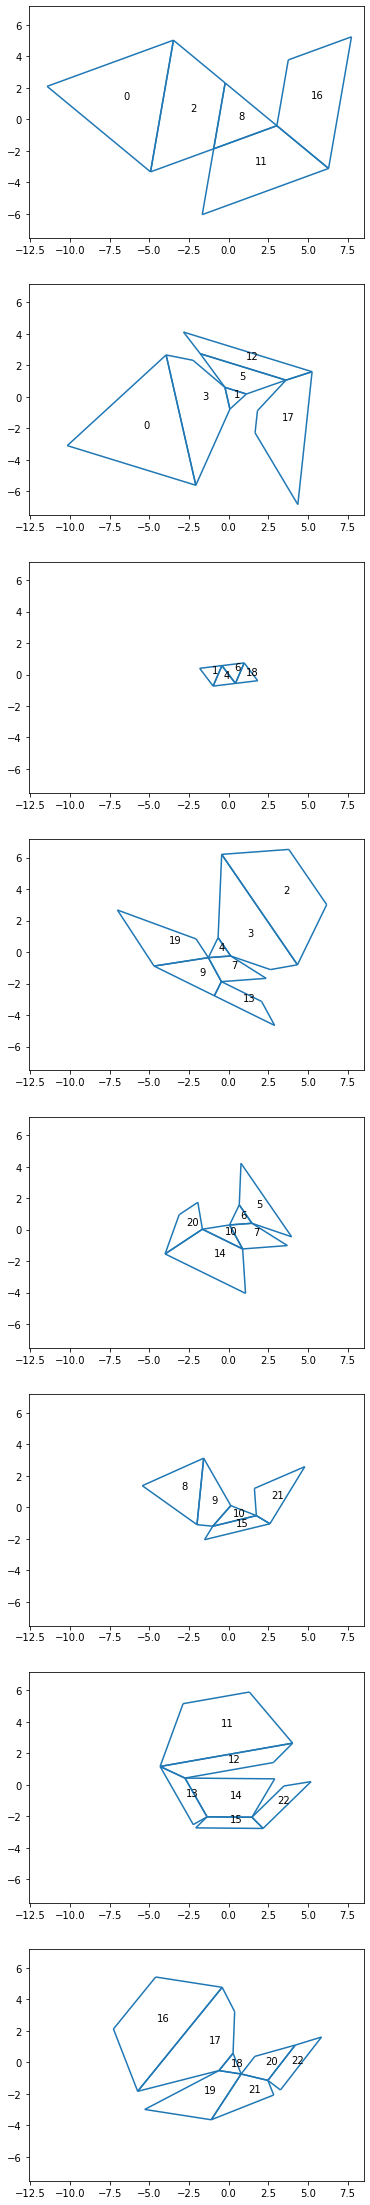

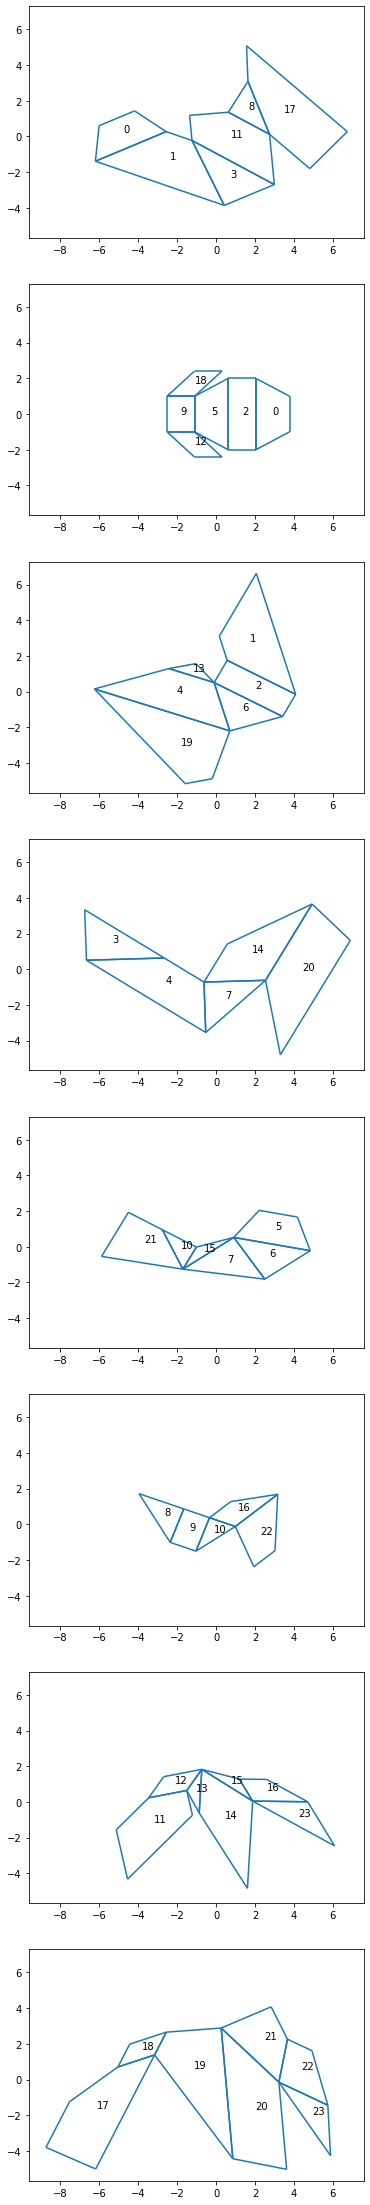

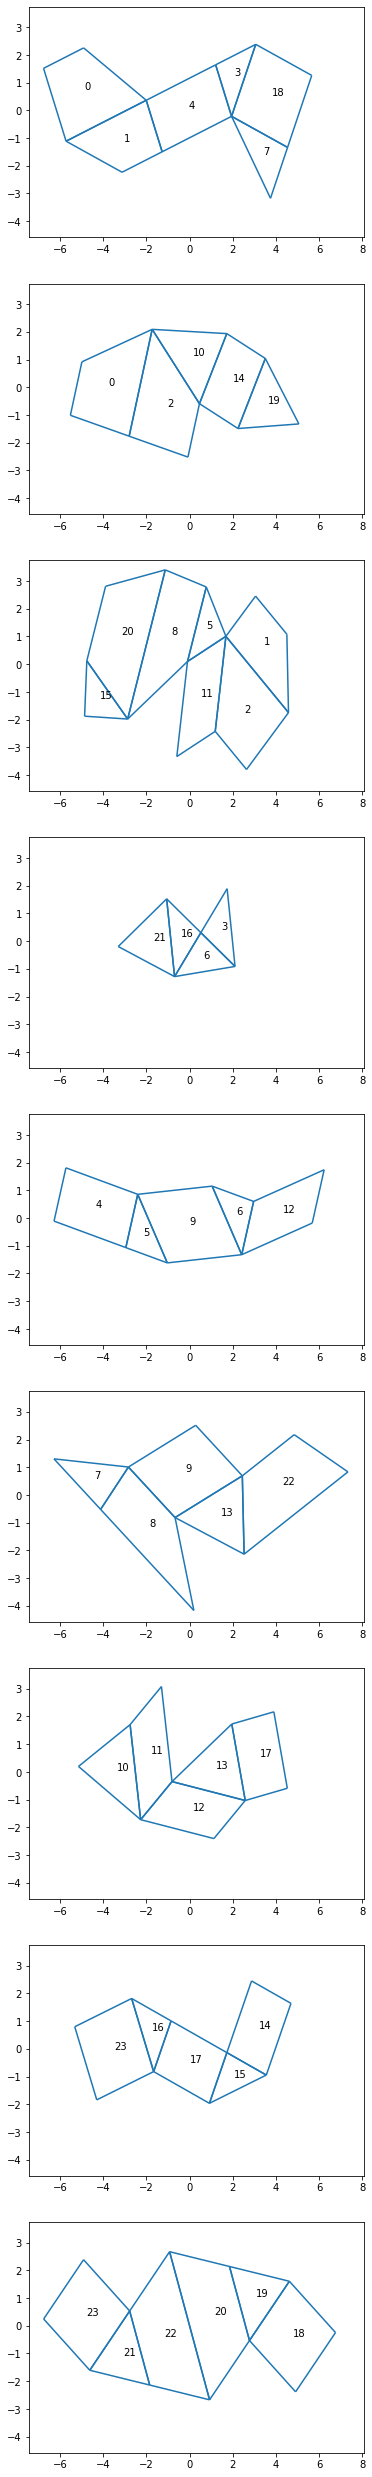

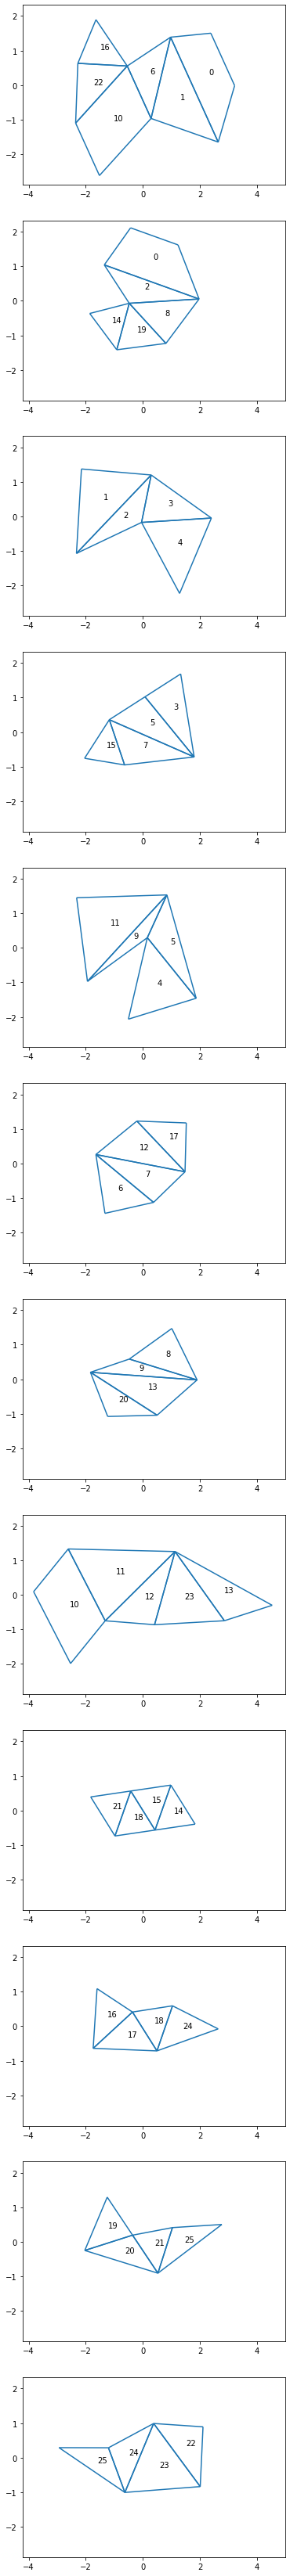

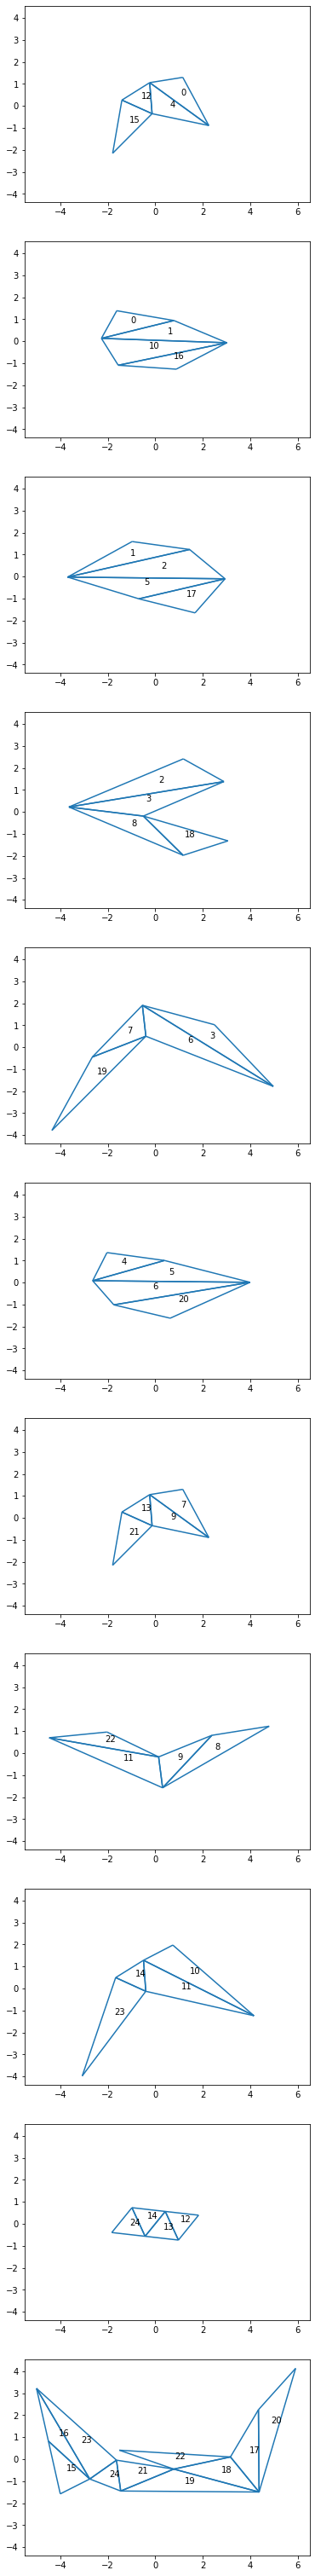

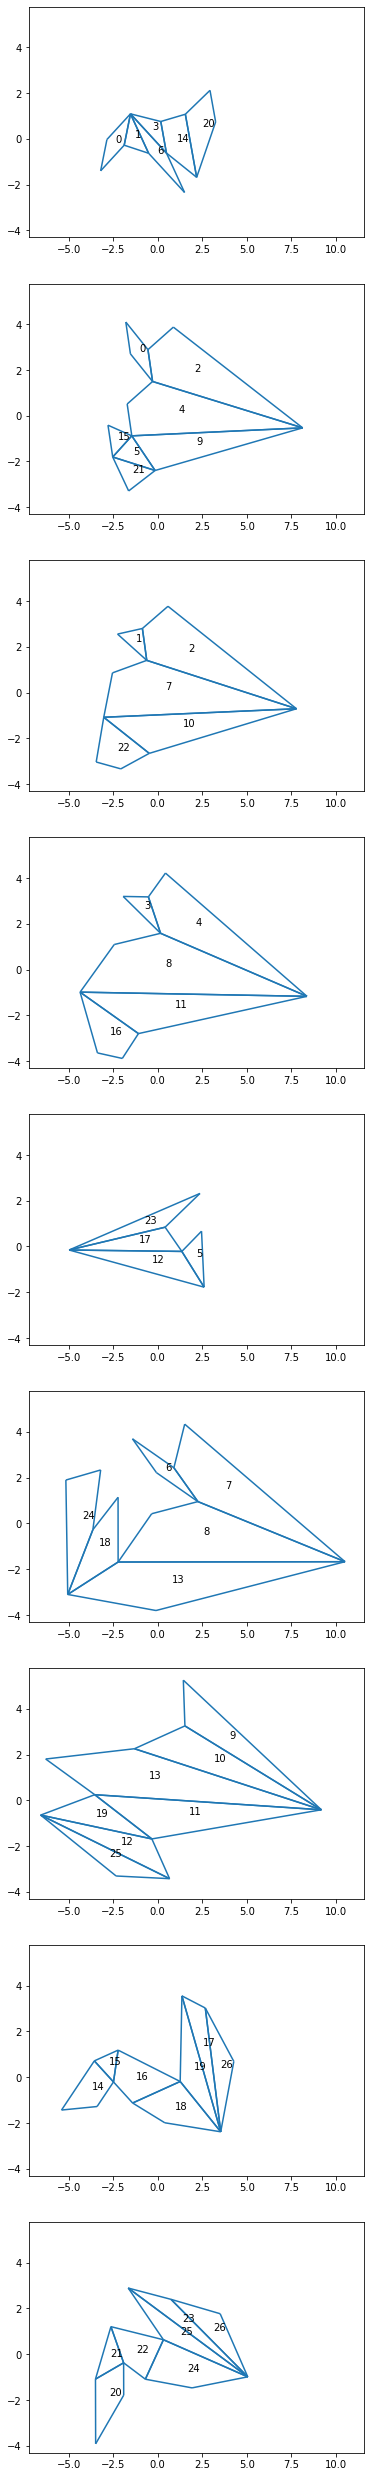

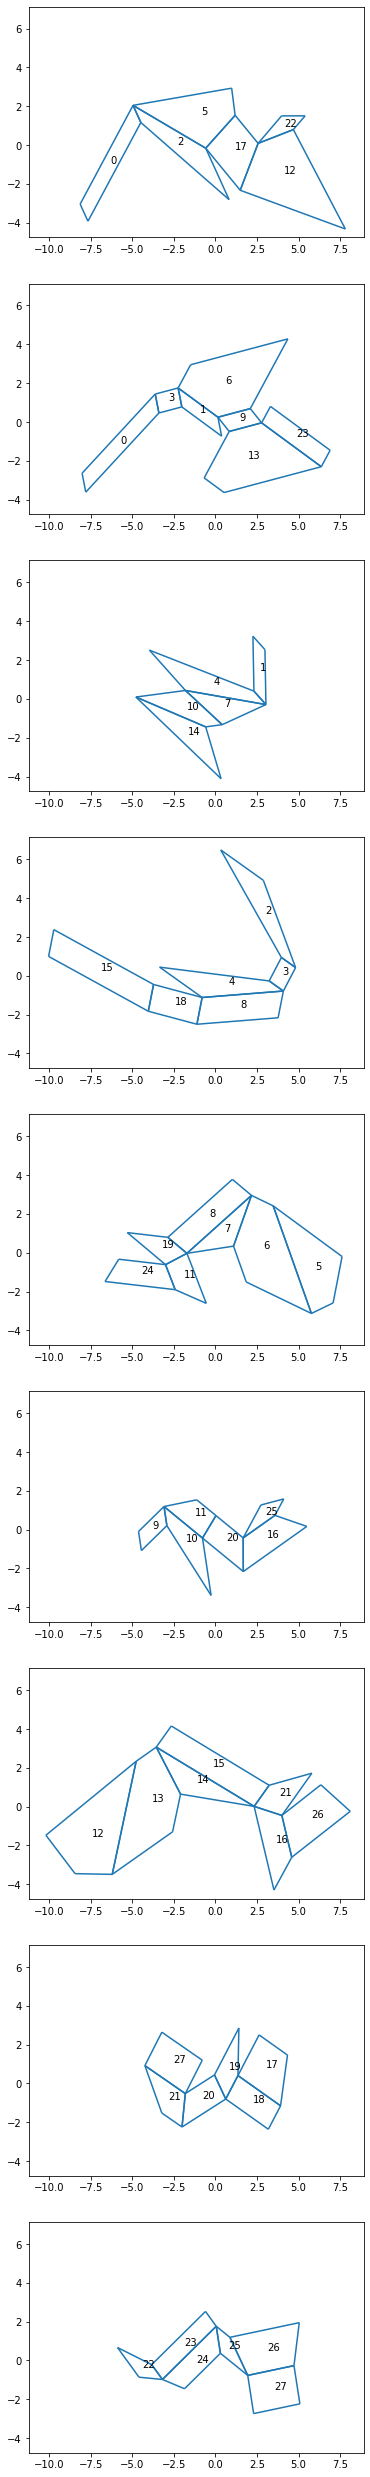

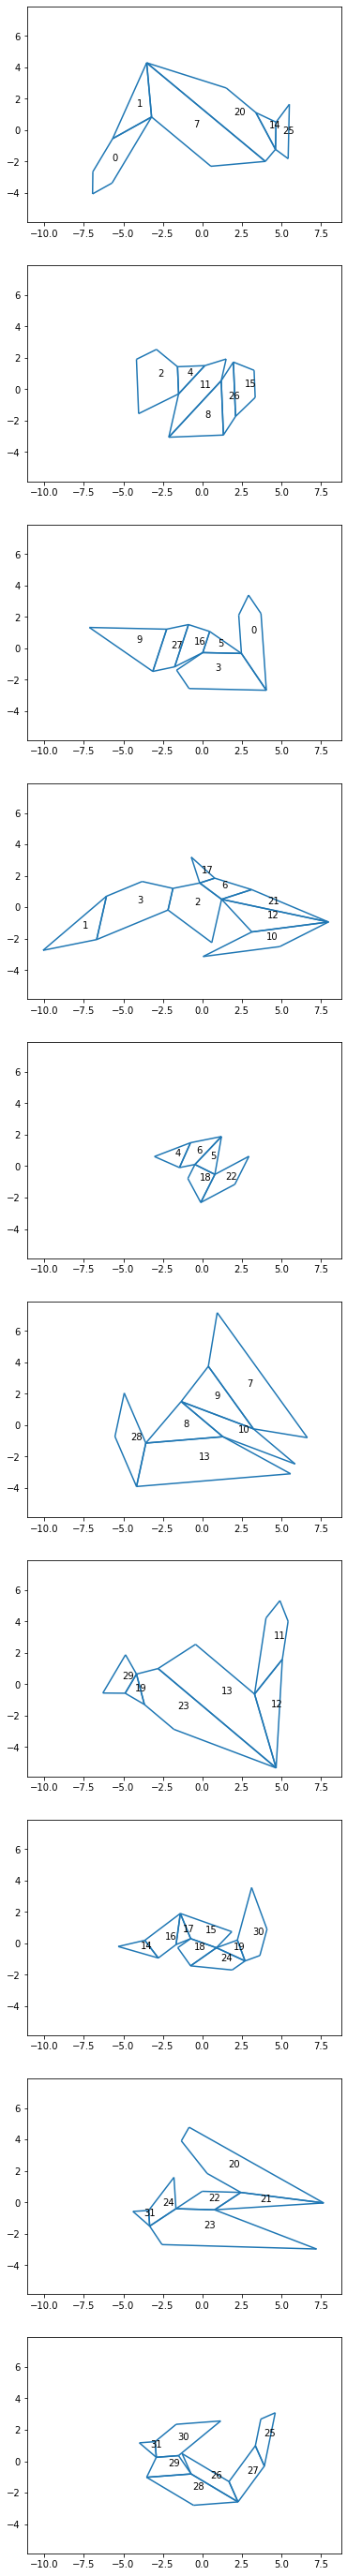

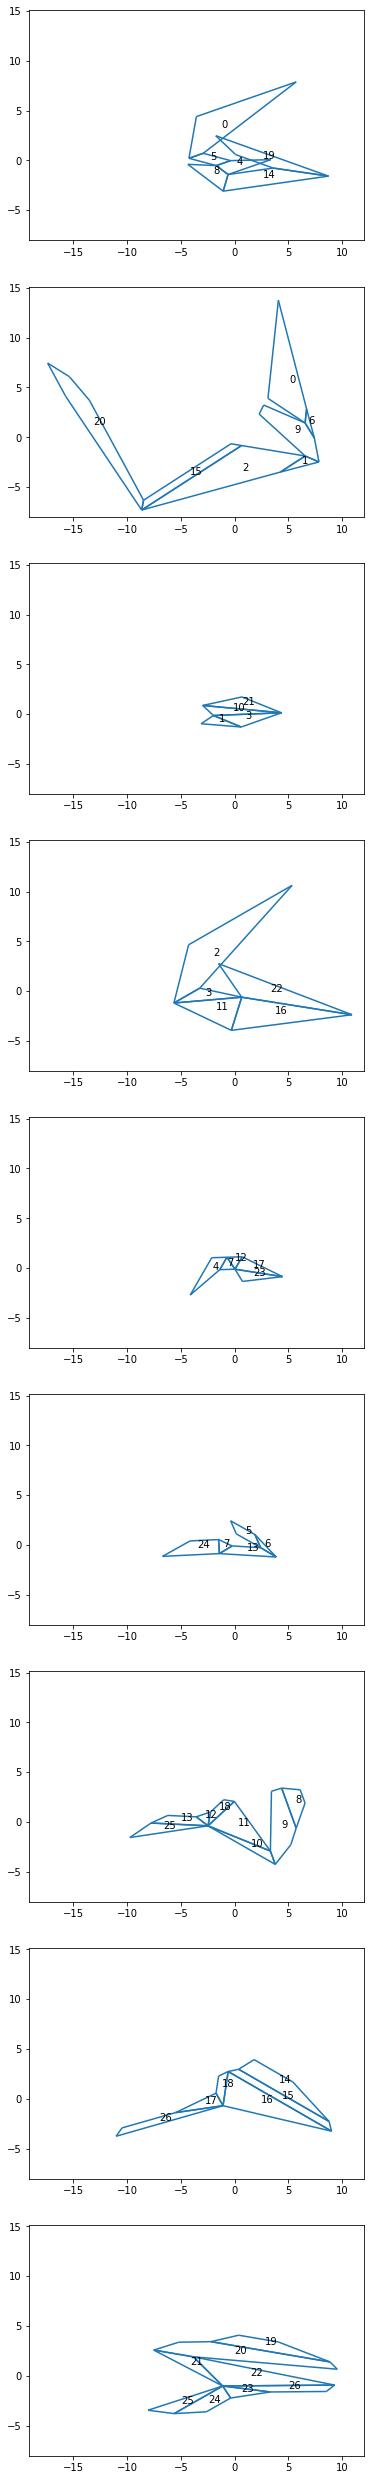

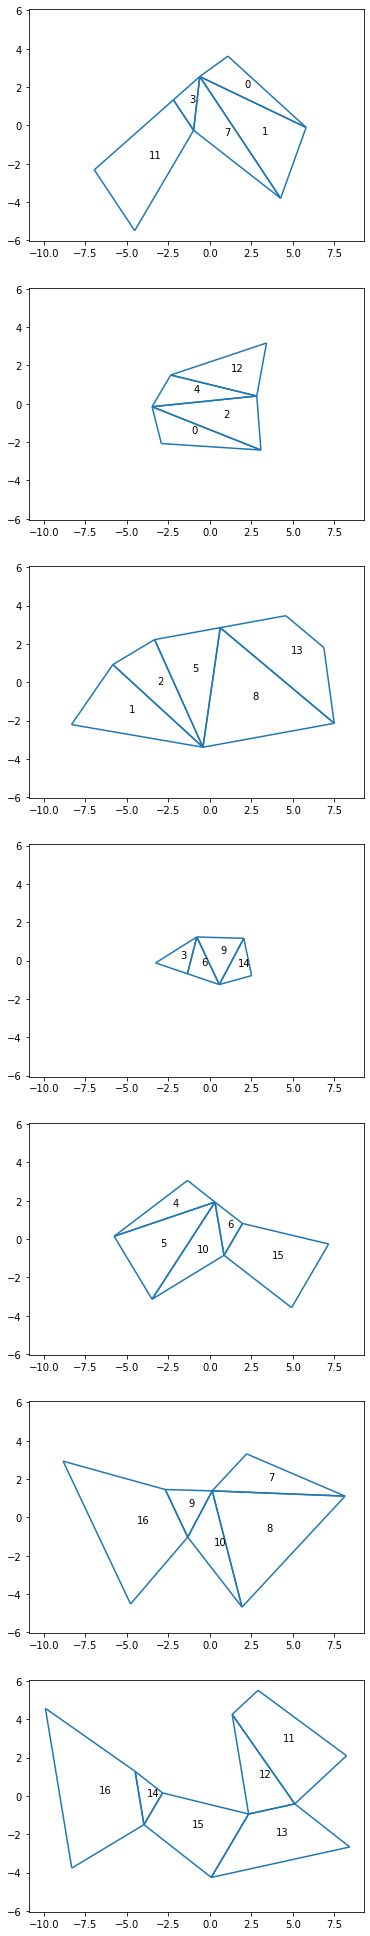

In [39]:
for name, poly in polys.items():
    save_nets(Tope.from_vertices(poly), f"figs/{name}.png")

In [ ]:
np.con